In [1]:
# https://www.kaggle.com/manikg/training-svm-classifier-with-hog-features
'''
Revised baseline SVM model trained with custom features
'''

'\nRevised baseline SVM model trained with custom features\n'

In [1]:
# Import libraries
from linear_classifier import *
from linear_svm import *
import time
import os
import numpy as np 
import json
import imghdr
from PIL import Image
from matplotlib import pyplot as plt
from skimage import color
from skimage.feature import hog, daisy
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score

In [32]:
def load_image( infilename ) :
    '''
    Helper function to manually load in images. Accepts image path infilename 
    and returns the numpy array representation of the image data
    (Need final X to be of dims (N, H, W, D))
    '''
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

def loadData(rootDir, featureType):
    '''
    Helper function which goes into one of our split dataset folders (train, val, test) to extract
    image data. Loads images, performs custom feature extraction, extracts class label from file name,
    and returns two numpy arrays X and y with data / labels for all examples in rootDir
    '''
    featList = []
    labelList = []
    imgList = []
    ppc = 8
    for c in os.listdir(rootDir):
        for file in os.listdir(os.path.join(rootDir, c)):
            filePath = os.path.join(rootDir, c, file)
            if imghdr.what(filePath):
                imRaw = load_image(filePath)
                if featureType == "hog":
                    feature, featImg = hog(imRaw, orientations=8, pixels_per_cell=(ppc,ppc), block_norm = "L1",
                                    feature_vector = True, visualize = True, cells_per_block=(4,4)) # HOG Features
                elif featureType == "daisy":
                    imGray = color.rgb2gray(imRaw)
                    feature = daisy(imGray, step=4, radius=15, rings=3, histograms=8, orientations=8,
                                    normalization="l1", visualize = False) # DAISY Features (similar to SIFT)
                # Note: dataset-split/val\compost\compost168.jpg may not be resized yet!
                else:
                    print("Invalid custom feature type specified")
                    exit(0)
                if imRaw.shape != (384, 512, 3):
                    print("Skipping dimension-incompatible image {}".format(file))
                    continue
                featList.append(feature)
                imgList.append(featImg)
                labelList.append(c)
                
    X = np.stack(tuple(featList))
    y = np.array(labelList)
    return X, y, imgList

In [34]:
'''
Load in the training and validation data and perform HOG feature extraction.
'''
X_train, y_train, trainImgs = loadData("../../datasets/trashnet/data/dataset-split/train", "hog")
X_val, y_val, valImgs = loadData("../../datasets/trashnet/data/dataset-split/val", "hog")

Skipping dimension-incompatible image compost168.jpg


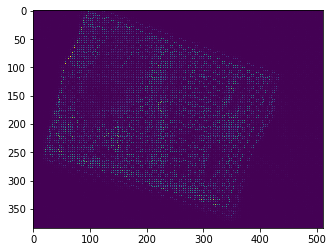

In [75]:
# Visualize an output image
import scipy.misc
plt.imshow(trainImgs[1026])
# scipy.misc.imsave("hog4.jpg", trainImgs[660])

In [77]:
# Sanity check dimensions
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(1438, 1488000)
(1438,)
(719, 1488000)
(719,)


In [76]:
# Preprocessing: subtract the mean image
mean_image = np.mean(X_train, axis=0)
X_train = X_train.astype(float) - mean_image
X_val = X_val.astype(float) - mean_image

MemoryError: 

In [78]:
# Append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])

In [79]:
# Encode the class labels
from sklearn.preprocessing import LabelEncoder
classes = ["cardboard", "compost", "glass", "metal", "paper", "plastic", "trash"]
le = LabelEncoder()
le.fit(classes)
y_train = le.transform(y_train)
y_val = le.transform(y_val)

In [80]:
# TRAIN THE MODEL
svm = LinearSVM()
tic = time.time()
print("Training model with {} rows of training data".format(X_train.shape[0]))
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('Training Complete. That took %fs' % (toc - tic))

Training model with 1438 rows of training data
iteration 0 / 1500: loss 130145.306818


KeyboardInterrupt: 

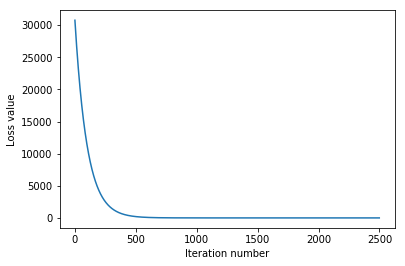

In [27]:
# Plot the loss as a function iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [28]:
# Validation set accuracy
y_val_pred = svm.predict(X_val)
val_accuracy = np.mean(y_val == y_val_pred)
print('Baseline validation set accuracy is %f' % val_accuracy)

Baseline validation set accuracy is 0.401947


In [29]:
# Training set accuracy
y_train_pred = svm.predict(X_train)
train_accuracy = np.mean(y_train == y_train_pred)
print('Baseline train set accuracy is %f' % train_accuracy)

Baseline train set accuracy is 0.511822


In [31]:
# Serialize and persist the trained model
import pickle
outName = "hog_baseline_trained.p"
pickle.dump(svm, open(outName, "wb"))